In [24]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import *

In [25]:
dataset = pd.read_csv('dataset.csv')

In [26]:
test_split=round(len(dataset)*0.20)
df_for_training=dataset[:-test_split]
df_for_testing=dataset[-test_split:]
print("shape del training set: {}".format(df_for_training.shape))
print("shape del test set: {}".format(df_for_testing.shape))


shape del training set: (1000427, 6)
shape del test set: (250107, 6)


In [27]:
# Normalizzazione
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled= scaler.transform(df_for_testing)
df_for_training_scaled

array([[0.11842309, 0.4892513 , 0.51676206, 0.54466859, 0.45378151,
        0.56907478],
       [0.01527774, 0.46182357, 0.40719542, 0.46493756, 0.3557423 ,
        0.55513308],
       [0.41996658, 0.42772424, 0.42763696, 0.48991354, 0.42577031,
        0.52471483],
       ...,
       [0.62809509, 0.48851001, 0.65004088, 0.67819404, 0.50840336,
        0.69835234],
       [0.36555162, 0.46478873, 0.60834015, 0.63208453, 0.49019608,
        0.65652725],
       [0.21755008, 0.41363973, 0.64431725, 0.76945245, 0.4859944 ,
        0.84030418]])

In [28]:
#n_past is the number of step we will look in the past to predict the next target value.
col2pred = 4  # 0:steps, 1:bedin, 2:bedout, 3:sleep duration, 4:deep duration, 5:lightduration
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            #per ogni feature fa l'append dei precedenti
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            
            dataY.append(dataset[i,col2pred])
    return np.array(dataX),np.array(dataY)

window_size = 7
trainX,trainY=createXY(df_for_training_scaled,window_size)
testX,testY=createXY(df_for_testing_scaled,window_size)

In [29]:
# features num
features_num = dataset.shape[1]

# LSTM

In [30]:
#Creazione del modello
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(window_size,features_num)))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss = 'mse', optimizer = 'adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 7, 50)             11400     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 31,651
Trainable params: 31,651
Non-trainable params: 0
_________________________________________________________________


In [31]:
history = model.fit(trainX, trainY, epochs = 2, verbose = 1, batch_size = 4096, validation_split=0.2) # 8192

Epoch 1/2
196/196 [==============================] - 27s 120ms/step - loss: 0.0238 - val_loss: 0.0155
Epoch 2/2
196/196 [==============================] - 23s 118ms/step - loss: 0.0164 - val_loss: 0.0151


In [32]:
prediction_train = model.predict(trainX)
print("prediction\n", prediction_train)
print("\nPrediction Shape-", prediction_train.shape)

prediction_train_copies_array = np.repeat(prediction_train, 6, axis=-1)
pred_train = scaler.inverse_transform(np.reshape(prediction_train_copies_array, (len(prediction_train), 6)))[:, col2pred]
true_value_train_copies_array = np.repeat(trainY, 6, axis=-1)
true_value_train = scaler.inverse_transform(np.reshape(true_value_train_copies_array, (len(trainY), 6)))[:, col2pred]

prediction_test=model.predict(testX)
print("prediction\n", prediction_test)
print("\nPrediction Shape-",prediction_test.shape)

prediction_copies_test_array = np.repeat(prediction_test,6, axis=-1)
pred_test=scaler.inverse_transform(np.reshape(prediction_copies_test_array,(len(prediction_test),6)))[:,col2pred]
true_value_test_copies_array = np.repeat(testY,6, axis=-1)
true_value_test=scaler.inverse_transform(np.reshape(true_value_test_copies_array,(len(testY),6)))[:,col2pred]

31264/31264 [==============================] - 79s 3ms/step
prediction
 [[0.40173072]
 [0.40483332]
 [0.39756426]
 ...
 [0.44188538]
 [0.43051136]
 [0.42661294]]

Prediction Shape- (1000420, 1)
7816/7816 [==============================] - 21s 3ms/step
prediction
 [[0.43757197]
 [0.4662503 ]
 [0.46610904]
 ...
 [0.4294435 ]
 [0.43288475]
 [0.4378842 ]]

Prediction Shape- (250100, 1)


**********TRAIN-SET***********
MAE: 0.677
MSE: 0.767
RMSE: 0.767
**********TEST-SET***********
MAE: 0.688
MSE: 0.790
RMSE: 0.790


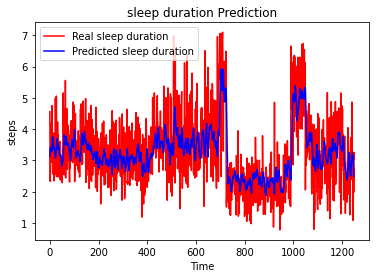

In [33]:
def metrics(true_value_train, pred_value_train, true_value_test, pred_value_test):
    print("**********TRAIN-SET***********")
    print("MAE: {:.3f}".format(mean_absolute_error(
        true_value_train, pred_value_train)))
    print("MSE: {:.3f}".format(
        mean_squared_error(true_value_train, pred_value_train)))
    print("RMSE: {:.3f}".format(
        mean_squared_error(true_value_train, pred_value_train, squared=True)))
    # metrics test set
    print("**********TEST-SET***********")
    print("MAE: {:.3f}".format(mean_absolute_error(
        true_value_test, pred_value_test)))
    print("MSE: {:.3f}".format(
        mean_squared_error(true_value_test, pred_value_test)))
    print("RMSE: {:.3f}".format(
        mean_squared_error(true_value_test, pred_value_test, squared=True)))
    

    plt.plot(true_value_test[:1250], color='red', label='Real sleep duration')
    plt.plot(pred_value_test[:1250], color='blue', label='Predicted sleep duration')
    plt.title('sleep duration Prediction')
    plt.xlabel('Time')
    plt.ylabel('steps')
    plt.legend()
    plt.show()


metrics(true_value_train, pred_train, true_value_test, pred_test)
